In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
path = 'D:/Datasets/flood dataset - kaggle/flood prediction/datasets_1686_3183_rainfall in india 1901-2015.csv'
dataframe = pd.read_csv(path, na_values=['na', '--'])
dataframe.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3
1,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7
2,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6
3,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0
4,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8


In [4]:
# Filling NULL with mean of each values of column, because nun values will cause error in the following way
dataframe['JAN'].fillna((dataframe['JAN'].mean()), inplace=True)
dataframe['FEB'].fillna((dataframe['FEB'].mean()), inplace=True)
dataframe['MAR'].fillna((dataframe['MAR'].mean()), inplace=True)
dataframe['APR'].fillna((dataframe['APR'].mean()), inplace=True)
dataframe['MAY'].fillna((dataframe['MAY'].mean()), inplace=True)
dataframe['JUN'].fillna((dataframe['JUN'].mean()), inplace=True)
dataframe['JUL'].fillna((dataframe['JUL'].mean()), inplace=True)
dataframe['AUG'].fillna((dataframe['AUG'].mean()), inplace=True)
dataframe['SEP'].fillna((dataframe['SEP'].mean()), inplace=True)
dataframe['OCT'].fillna((dataframe['OCT'].mean()), inplace=True)
dataframe['DEC'].fillna((dataframe['DEC'].mean()), inplace=True)

In [5]:
# Here, each month has been separated into a column with its value
df_month = pd.DataFrame(dataframe[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL','AUG', 'SEP', 'OCT']])
df_month = df_month.T
df_month = df_month.unstack(level=0)
df_month = df_month.reset_index()

# Creation of year/month in a separate column
df_time = pd.Series(pd.period_range(start='1901', end='2016', freq='M', periods=None), dtype=str)
df_time = df_time.reset_index()

# To create a new datafarame which record the values of rainfall in the specific year and moth
df = pd.DataFrame({'Rainfall':df_month[0]})
display(df.head())
display(df.dtypes)

,Rainfall
0,49.2
1,87.1
2,29.2
3,2.3
4,528.8


Rainfall    float64
dtype: object

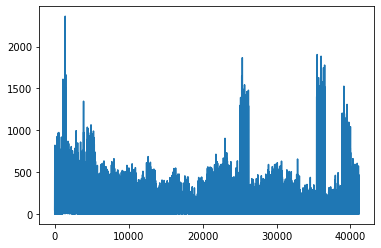

In [6]:
plt.plot(df)
plt.show()

In [7]:
# Convert pandas dataframe to numpy array
dataset = df.values
dataset = dataset.astype('float32')
dataset.shape

(41160, 1)

In [8]:
#Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

Note: we cannot use random way to split training and test data as the sequence of events 
is important for time series. In this case, we take first 60% values for train and the remaining
1/3 for testing split into train and test sets.

In [9]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(train_size)
print(test_size)

27165
13995


Here, it is not possible to fit the model as normally do for image processing using X and Y. In this case, we should transform the data into something that looks like X and Y values. So, it can be trained on a sequence rather than indvidual datapoints. 
Therefore we need to convert into n number of columns for X where we feed sequence of numbers
then the final column as Y where we provide the next number in the sequence as output.
Here, we convert an array of values into a dataset matrix

seq_size is the number of previous time steps to use as 
input variables to predict the next time period.

creates a dataset where X is the amount of rainfall at a given time (t, t-1, t-2...) 
and Y is the amount of rainfall at the next time (t + 1).

In [10]:
def to_sequences(dataset, se_size):
    x = []
    y = []
    
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x), np.array(y)

In [12]:
seq_size = 10    # Number of time steps to look back
#Larger sequences may improve forecasting
train_X, train_Y = to_sequences(train, seq_size)
test_X, test_Y = to_sequences(test, seq_size)

#Compare trainX and dataset. You can see that X= values at t, t+1 and t+2
#whereas Y is the value that follows, t+3 (since our sequence size is 3)

print("Shape of training set: {}".format(train_X.shape))
print("Shape of test set: {}".format(test_X.shape))

Shape of training set: (27154, 10)
Shape of test set: (13984, 10)


In [13]:
#Create Model
print("Deep Model")
#Fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
print(model.summary())

Deep Model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
model.fit(train_X, train_Y, validation_data=(test_X, test_Y), verbose= 2, epochs = 100)


Train on 27154 samples, validate on 13984 samples
Epoch 1/100
 - 2s - loss: 0.0017 - acc: 0.0489 - val_loss: 0.0015 - val_acc: 0.0547
Epoch 2/100
 - 2s - loss: 0.0015 - acc: 0.0489 - val_loss: 0.0016 - val_acc: 0.0547
Epoch 3/100
 - 2s - loss: 0.0015 - acc: 0.0489 - val_loss: 0.0015 - val_acc: 0.0547
Epoch 4/100
 - 2s - loss: 0.0015 - acc: 0.0489 - val_loss: 0.0015 - val_acc: 0.0547
Epoch 5/100
 - 2s - loss: 0.0015 - acc: 0.0489 - val_loss: 0.0017 - val_acc: 0.0547
Epoch 6/100
 - 2s - loss: 0.0015 - acc: 0.0489 - val_loss: 0.0015 - val_acc: 0.0547
Epoch 7/100
 - 2s - loss: 0.0015 - acc: 0.0489 - val_loss: 0.0015 - val_acc: 0.0547
Epoch 8/100
 - 2s - loss: 0.0015 - acc: 0.0489 - val_loss: 0.0015 - val_acc: 0.0547
Epoch 9/100
 - 2s - loss: 0.0014 - acc: 0.0489 - val_loss: 0.0015 - val_acc: 0.0547
Epoch 10/100
 - 2s - loss: 0.0014 - acc: 0.0489 - val_loss: 0.0015 - val_acc: 0.0547
Epoch 11/100
 - 2s - loss: 0.0014 - acc: 0.0489 - val_loss: 0.0016 - val_acc: 0.0547
Epoch 12/100
 - 2s - lo

Epoch 95/100
 - 2s - loss: 0.0012 - acc: 0.0489 - val_loss: 0.0017 - val_acc: 0.0547
Epoch 96/100
 - 2s - loss: 0.0012 - acc: 0.0489 - val_loss: 0.0016 - val_acc: 0.0547
Epoch 97/100
 - 2s - loss: 0.0012 - acc: 0.0489 - val_loss: 0.0015 - val_acc: 0.0547
Epoch 98/100
 - 2s - loss: 0.0012 - acc: 0.0489 - val_loss: 0.0016 - val_acc: 0.0547
Epoch 99/100
 - 2s - loss: 0.0012 - acc: 0.0489 - val_loss: 0.0016 - val_acc: 0.0547
Epoch 100/100
 - 2s - loss: 0.0012 - acc: 0.0489 - val_loss: 0.0017 - val_acc: 0.0547


In [15]:
#Make prediction
predict_train = model.predict(train_X)
predict_test = model.predict(test_X)

# Estimate model performance
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

predict_train = scaler.inverse_transform(predict_train)
trainY_inverse = scaler.inverse_transform([train_Y])
predict_test = scaler.inverse_transform(predict_test)
testY_inverse = scaler.inverse_transform([test_Y])

print(predict_train)
print(trainY_inverse)

[[-2.4616878]
 [39.587326 ]
 [72.50304  ]
 ...
 [17.740303 ]
 [16.35677  ]
 [21.934618 ]]
[[  0.         159.80000272  12.20000003 ...   0.20000001   5.40000019
    6.69999955]]


In [16]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], predict_train[:,0]))
print("Train score: %.2f RMSE" % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], predict_test[:,0]))
print("Test score: %.2f RMSE" % (testScore))

Train score: 80.30 RMSE
Test score: 97.88 RMSE


In [17]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
predict_train_plot = np.empty_like(dataset)
predict_train_plot[:,:] = np.nan
predict_train_plot[seq_size:len(predict_train)+seq_size, :] = predict_train

# shift test predictions for plotting
predict_test_plot = np.empty_like(dataset)
predict_test_plot[:,:] = np.nan
predict_test_plot[len(predict_train)+(seq_size*2)+1:len(dataset)-1, :] = predict_test

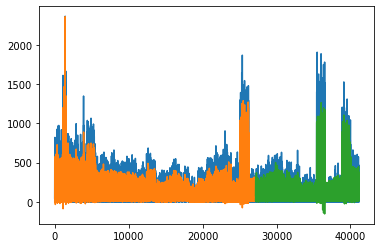

In [18]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.show()